# Rossaman Sales prediction with facebook Prophet

## The Problem
We have sales data from several stores and we want to predict sales in order to improve our stock logistics. 

## The solution 
Analyse data and perform a sales prediction study using facebook prophet. 

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [35]:
train_data = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates = True, low_memory = False)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Getting to know how the data is classified:

In [37]:
train_data.shape

(1017209, 9)

In [38]:
train_data['DayOfWeek'].unique()


array([5, 4, 3, 2, 1, 7, 6])

In [39]:
train_data['Open'].unique()

array([1, 0])

In [40]:
train_data['Promo'].unique()

array([1, 0])

In [41]:
train_data['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

a= Public Holiday
b= Easter
c= Christmas

In [42]:
train_data['SchoolHoliday'].unique()

array([1, 0])

In [43]:
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [44]:
store_data = pd.read_csv('../input/rossmann-store-sales/store.csv')
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [45]:
store_data.shape

(1115, 10)

In [46]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [47]:
store_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


To simplify further analysis, let's convert CompetitionDistance variable:

In [48]:
store_data['CompetitionDistance'] = store_data['CompetitionDistance']/1000
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1.27,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,0.57,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14.13,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,0.62,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29.91,4.0,2015.0,0,NaN,NaN,NaN


## Exploratory data analysis

### EDA for Train Dataset

Creating a heatmap for the sales train data 

In [49]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

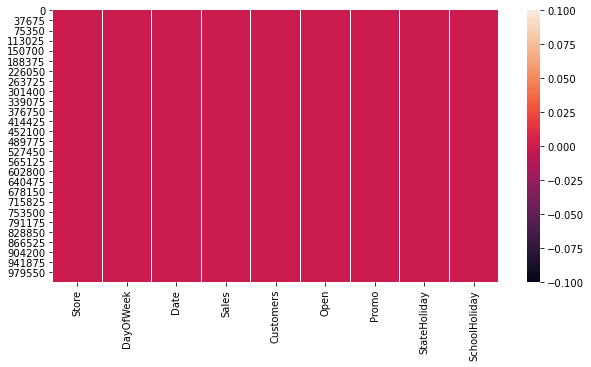

In [50]:
plt.figure(figsize = (10,5))
sns.heatmap(train_data.isnull());

There are no null values that must be treated. 

Now we will visualize graphically the variable contained in the train_data dataset

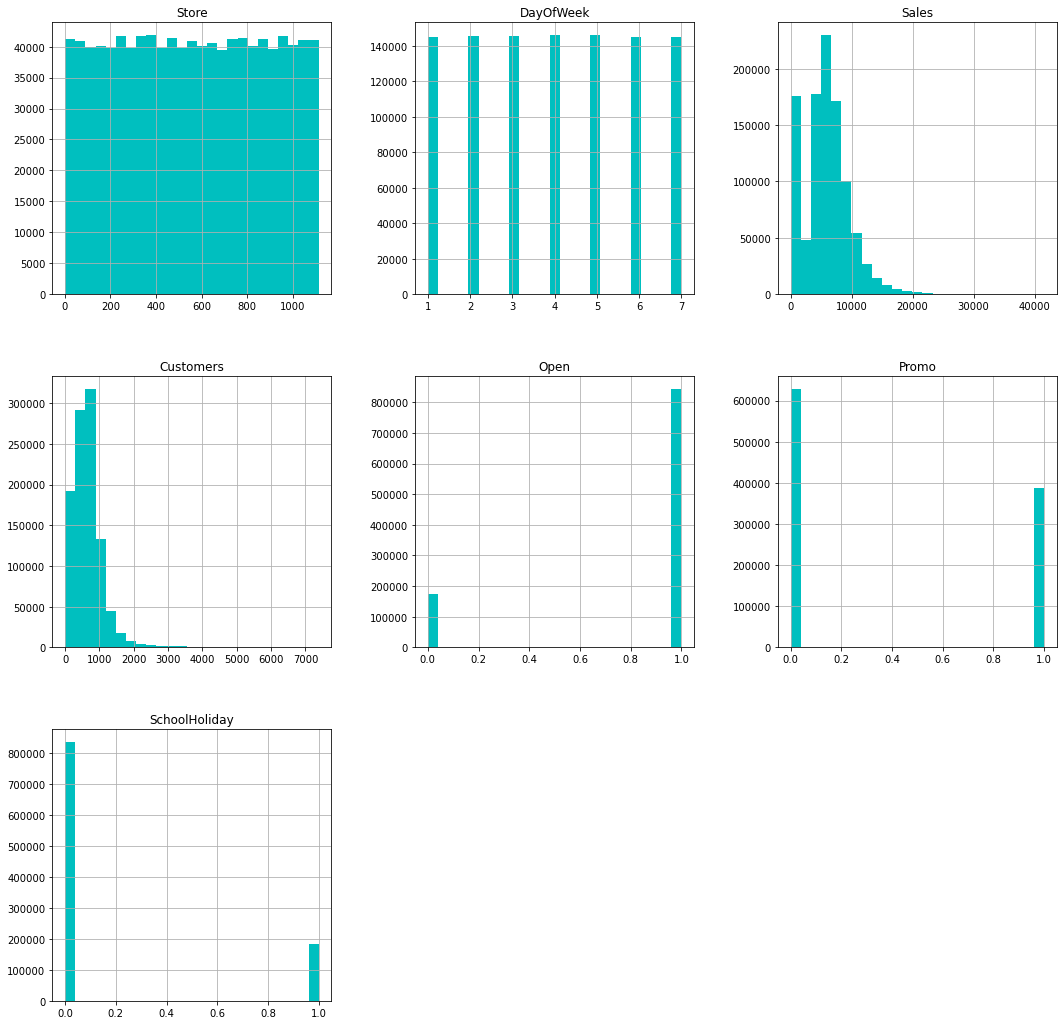

In [51]:
train_data.hist(bins = 25, figsize=(18, 18), color = 'c');

The most important information from these plots are:
- Most of the sales are happening around the value of 5 to 6 thousand euros
- Number of clients per day shows a greater frequency around 600
- The store was on sale (variable Promo) around 40% of the time it was open

Getting some important information quantitatively:

In [52]:
max_clients = train_data['Customers'].max()
ctrain_data = train_data[train_data['Open'] == 0]
otrain_data = train_data[train_data['Open'] == 1]

print("The maximum number of clients per day was {}.".format(max_clients))

#Number of registers classified as 'opened store' or 'closed store'
ctrain_data = train_data[train_data['Open'] == 0]
otrain_data = train_data[train_data['Open'] == 1]
n_closed = round(len(ctrain_data)/len(store_data),0)
n_open = round(len(otrain_data)/len(store_data),0)

print("The number of days with closed stores was {} and the number of days with open stores was {}".format(n_closed, n_open))



The maximum number of clients per day was 7388.
The number of days with closed stores was 155.0 and the number of days with open stores was 757.0


Now we will focus on the dataframe in which we have only registers from when the stores are open

In [53]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [54]:
train_data.drop(['Open'], axis = 1, inplace=True)
train_data

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,a,1


In [55]:
#statistics for the new dataframe
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00


We can see from this new analysis that, when we deleted the registers for the days the store was closed, the statistics changed. 

Before, with all the data points, the mean for the sales was of around 5773 now it is 6955. The mean of the number of customers is another important variable that changed, going from 622 to 762 now. 

### EDA for Stores Dataset

In [56]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

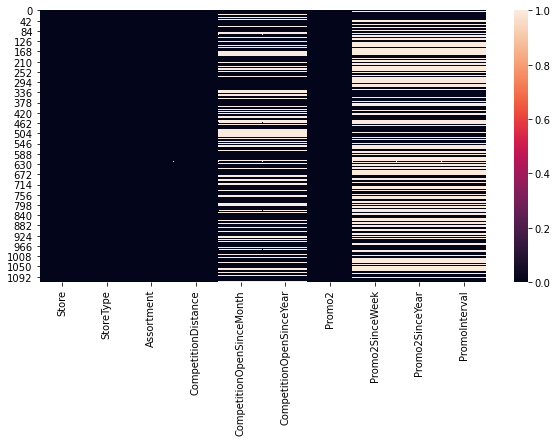

In [57]:
plt.figure(figsize = (10,5))
sns.heatmap(store_data.isnull());

Checking the missing data:

In [58]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [59]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1.07,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,0.31,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3.27,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3.24,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1.04,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1.13,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,0.54,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,0.87,NaN,NaN,0,NaN,NaN,NaN


In [60]:
store_data[store_data['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1.07,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,0.31,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3.27,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3.24,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1.04,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1.13,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,0.54,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,0.87,NaN,NaN,0,NaN,NaN,NaN


In [61]:
store_data[store_data['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1.27,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,0.62,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29.91,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,0.31,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24.00,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,0.54,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,0.90,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1.88,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9.26,NaN,NaN,0,NaN,NaN,NaN


#### Filling the missing numbers:
We have missing numbers in variables related to dates (weeks, years), so we have discrete points instead of a continuous variable that could have missing numbers filled by the mean, for example. 

In [62]:
miss_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in miss_cols:
  store_data[str].fillna(0, inplace=True)

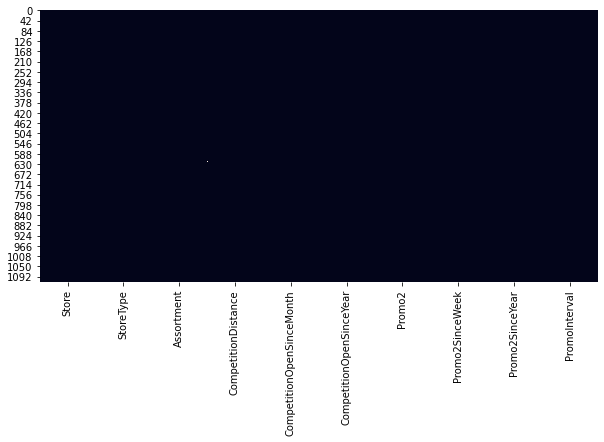

In [63]:
plt.figure(figsize = (10,5))
sns.heatmap(store_data.isnull(), cbar = False);

Now we do not have null data, except for the variable CompetitionDistance that must be treated now. In this case we have a continuous variable, as it is represented by the distance between the store and its competitors. We can fill missing numbers using the mean, as seen below: 

In [64]:
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].mean(), inplace = True)

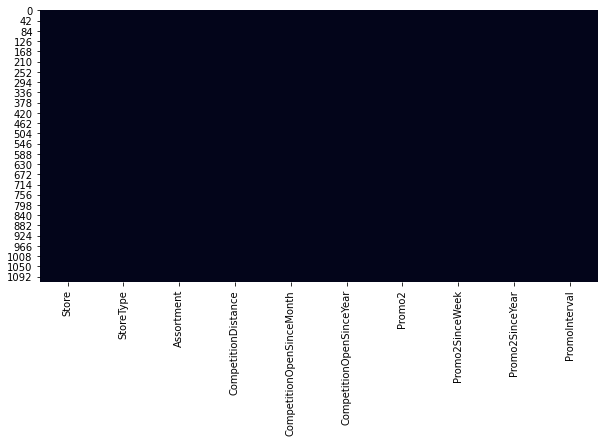

In [65]:
plt.figure(figsize = (10,5))
sns.heatmap(store_data.isnull(), cbar = False);

In [66]:
#### Now the dataset is free from missing data. 

Now we will visualize graphically the variables contained in the stores dataframe

SyntaxError: invalid syntax (<ipython-input-66-12a6cbec1e96>, line 3)

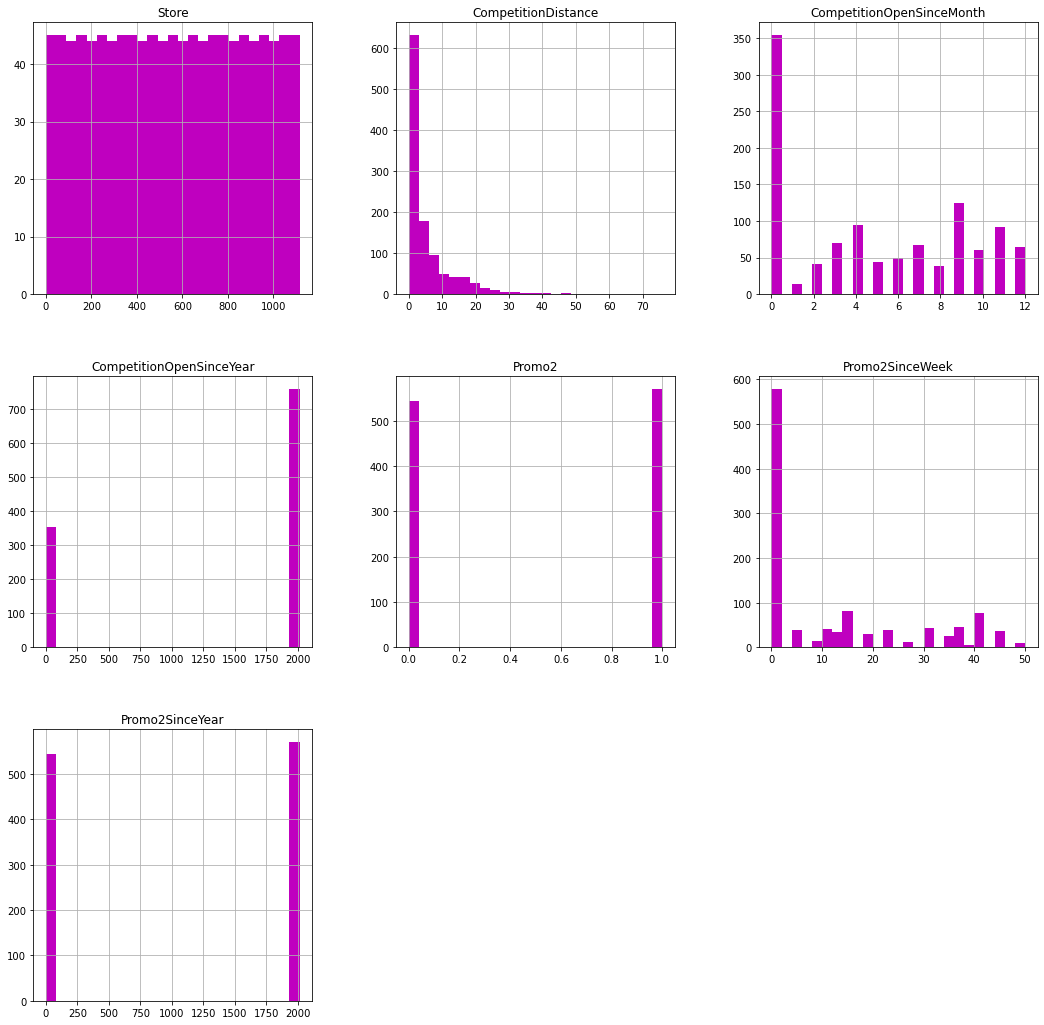

In [108]:
store_data.hist(bins = 25, figsize=(18,18
                                   ), color = 'm');

#### Main points from this data:
- Most of the store's competitors are within 10 km distance
- Around half of the stores take part in the aditional sales campaign


### Merging the dataframes Store and Train

We will use the store id ('Store' column) as a common variable between both dataframes

In [68]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [69]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,0.57,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14.13,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,0.62,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29.91,4.0,2015.0,0,0.0,0.0,0


In [70]:
merged_data = pd.merge(train_data, store_data, how = 'inner', on = 'Store')
merged_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0


In [71]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1017209 non-null  float64
 11  CompetitionOpenSinceMonth  1017209 non-null  float64
 12  CompetitionOpenSinceYear   1017209 non-null  float64
 13  Promo2      

In [72]:
merged_data.shape

(1017209, 17)

Now let's visualize the correlations between variables

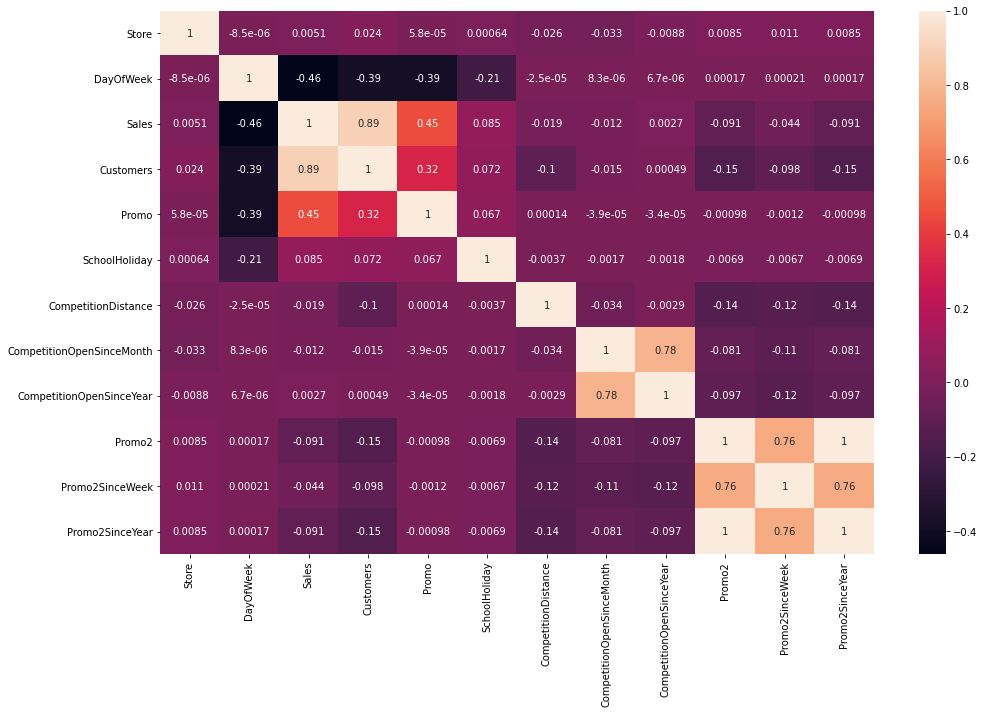

In [73]:
correlations = merged_data.corr()
f, ax = plt.subplots(figsize=(16,10))
sns.heatmap(correlations, annot = True);

#### Some conclusions from the correlation matrix: 
- The obvious correlations are: 
    - Sales are strongly correlated to the 'customers'variable 
    - Sales are moderately correlated to the 'promo' variable, meaning that promotions may have an impact on sales but it is not that much strong. 
- Some interesting correlations are: 
    - Additional promotions (variable 'Promo2') does not have a great impact on the volume of sales as the correlation is of -0,091. Sometimes we may expect that more promotions are what is needed to increase sales but that is not always true. 

In [74]:
#Another way to see the correlations, tin this case, related to sales. 
correlations = merged_data.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.462125
Promo2SinceYear             -0.091056
Promo2                      -0.091040
Promo2SinceWeek             -0.044143
CompetitionDistance         -0.019207
CompetitionOpenSinceMonth   -0.012431
CompetitionOpenSinceYear     0.002749
Store                        0.005126
SchoolHoliday                0.085124
Promo                        0.452345
Customers                    0.894711
Sales                        1.000000
Name: Sales, dtype: float64

In [75]:
#Related to number of customers:
correlations2 = merged_data.corr()['Customers'].sort_values()
correlations2

DayOfWeek                   -0.386445
Promo2                      -0.150159
Promo2SinceYear             -0.150138
CompetitionDistance         -0.102777
Promo2SinceWeek             -0.098323
CompetitionOpenSinceMonth   -0.015188
CompetitionOpenSinceYear     0.000489
Store                        0.024325
SchoolHoliday                0.071568
Promo                        0.316169
Sales                        0.894711
Customers                    1.000000
Name: Customers, dtype: float64

### Visualising the data with time series

In [76]:
merged_data['Year'] = pd.DatetimeIndex(merged_data['Date']).year
merged_data['Month'] = pd.DatetimeIndex(merged_data['Date']).month
merged_data['Day'] = pd.DatetimeIndex(merged_data['Date']).day
merged_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,27


#### Monthly Analysis

Text(0.5, 1.0, 'Average sales per month')

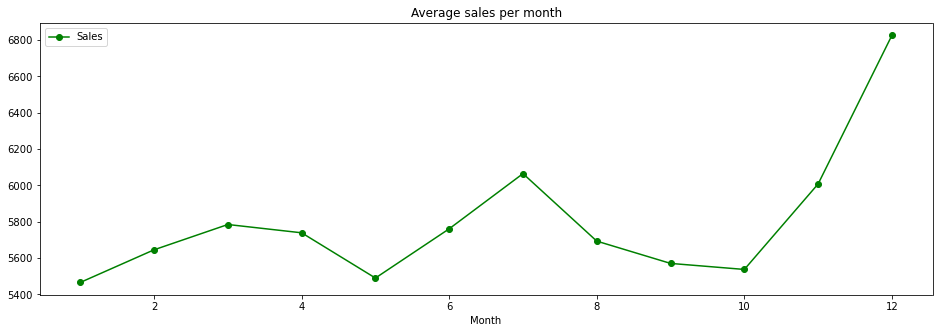

In [77]:
axis = merged_data.groupby('Month')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'g')
axis.set_title('Average sales per month')

Text(0.5, 1.0, 'Average clients per month')

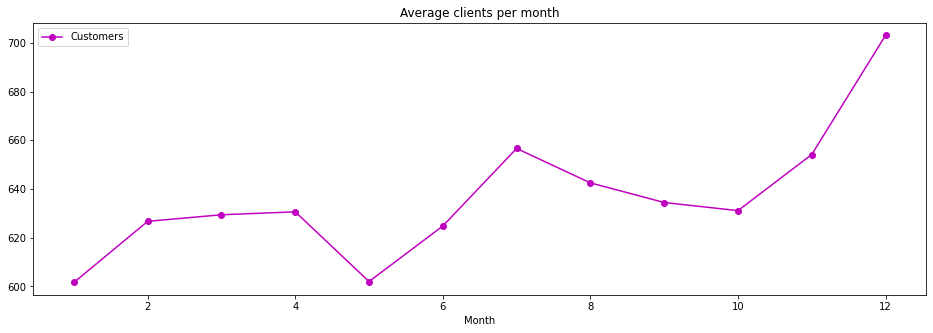

In [78]:
axis = merged_data.groupby('Month')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'm')
axis.set_title('Average clients per month')

- Clearly we can see an influence from Christmas in the the sales, with peak of number of clients in December. 
- Another small peak appears around the month of July, when it is summer vacations and probably there are more people going to the shops. 
- Around Janurary and February the number of clients is low, and this may be explained by the fact that these are the winter months after christmas. 

#### Daily Analysis

Text(0.5, 1.0, 'Average Sales per Day')

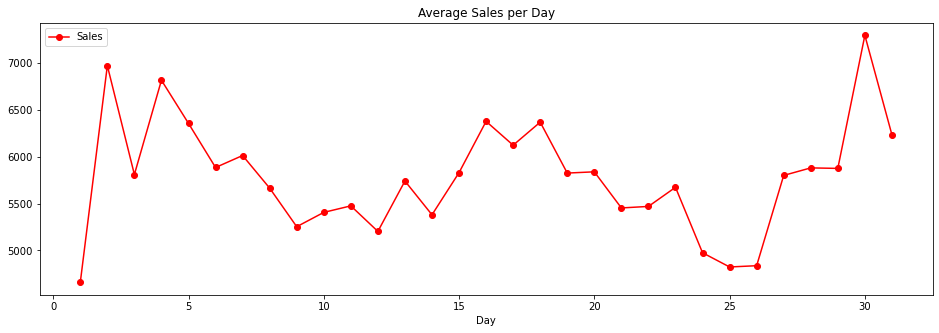

In [79]:
axis = merged_data.groupby('Day')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'r')
axis.set_title('Average Sales per Day')

Text(0.5, 1.0, 'Average clients per day')

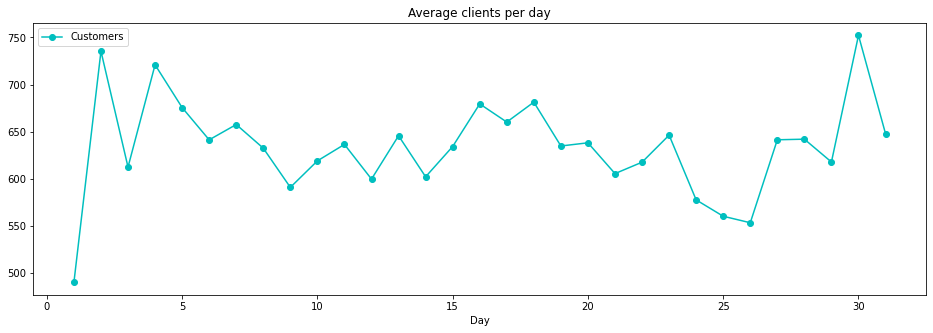

In [80]:
axis = merged_data.groupby('Day')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'c')
axis.set_title('Average clients per day')

#### Day of the Week analysis

Text(0.5, 1.0, 'Average sales per day of the week')

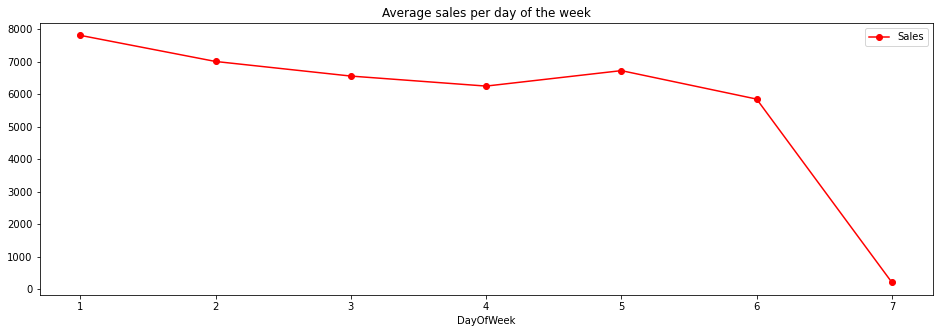

In [81]:
axis = merged_data.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (16,5), marker = 'o', color = 'r')
axis.set_title('Average sales per day of the week')

Text(0.5, 1.0, 'Average customers per day of the week')

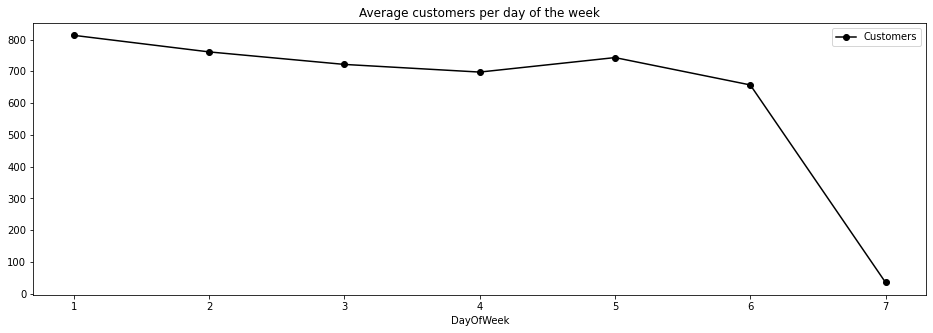

In [82]:
axis = merged_data.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (16,5), marker = 'o', color = 'k')
axis.set_title('Average customers per day of the week')

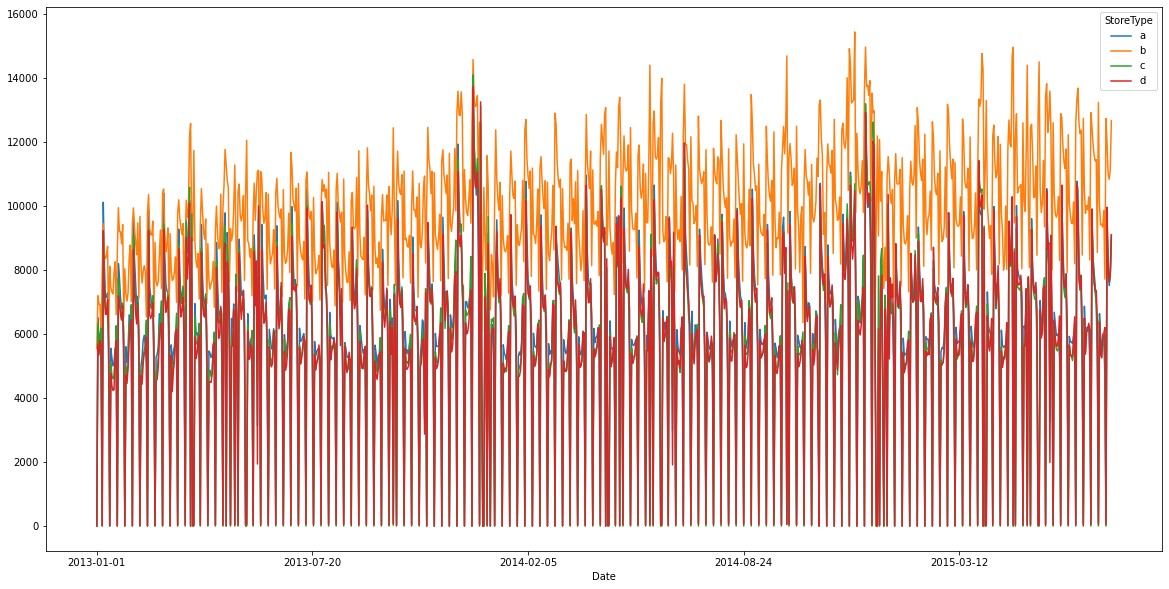

In [83]:
fig, ax = plt.subplots(figsize = (20,10))
merged_data.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax);

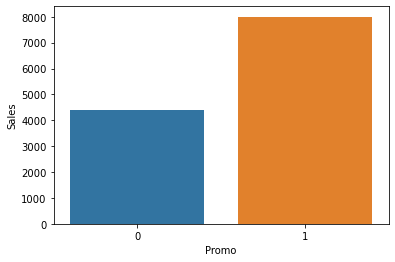

In [84]:
sns.barplot(x = 'Promo', y = 'Sales', data = merged_data);

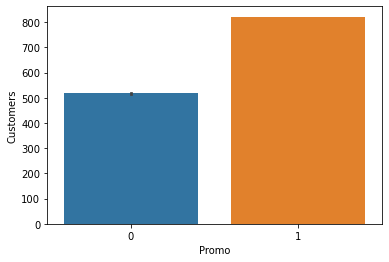

In [85]:
sns.barplot(x = 'Promo', y = 'Customers', data = merged_data);

## Predicting sales with Facebook Prophet

In [86]:
!pip install fbprophet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [87]:
from fbprophet import Prophet

In [88]:
def sales_prediction(store_id, sales_data, periods):
  sales_data = sales_data[sales_data['Store'] == store_id]
  sales_data = sales_data[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_data = sales_data.sort_values(by = 'ds')

  model = Prophet()
  model.fit(sales_data)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  fig1 = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
  fig2 = model.plot_components(forecast)

  return sales_data, forecast

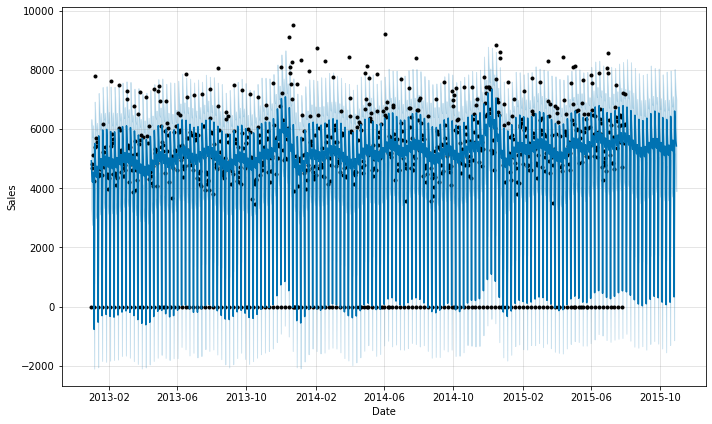

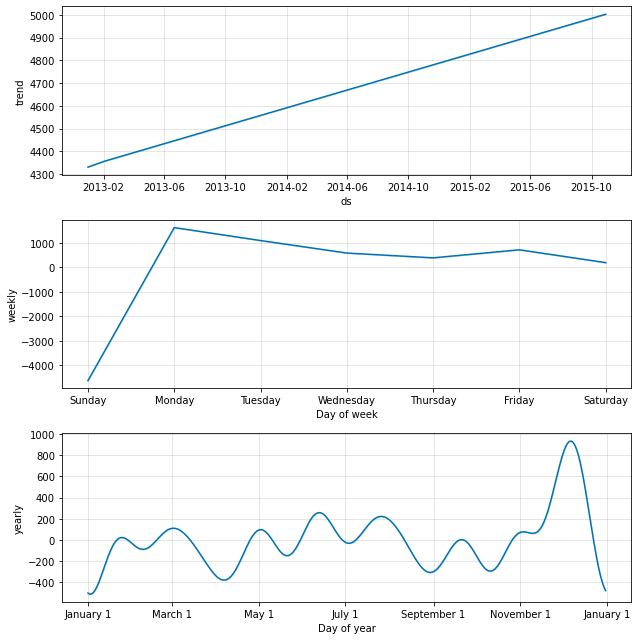

In [89]:
df_origin, df_prediction = sales_prediction(10, merged_data, 90)

In [90]:
df_origin.shape, df_prediction.shape

((942, 2), (1032, 19))

In [91]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,4330.465276,3322.572239,6337.409572,4330.465276,4330.465276,598.651188,598.651188,598.651188,1101.082105,1101.082105,1101.082105,-502.430917,-502.430917,-502.430917,0.0,0.0,0.0,4929.116464
1,2013-01-02,4331.265370,2949.880116,6015.795615,4331.265370,4331.265370,77.342438,77.342438,77.342438,589.100393,589.100393,589.100393,-511.757955,-511.757955,-511.757955,0.0,0.0,0.0,4408.607808
2,2013-01-03,4332.065463,2758.259587,5730.194291,4332.065463,4332.065463,-120.819683,-120.819683,-120.819683,392.345869,392.345869,392.345869,-513.165553,-513.165553,-513.165553,0.0,0.0,0.0,4211.245780
3,2013-01-04,4332.865557,3044.858589,6127.086903,4332.865557,4332.865557,214.868600,214.868600,214.868600,721.964023,721.964023,721.964023,-507.095424,-507.095424,-507.095424,0.0,0.0,0.0,4547.734156
4,2013-01-05,4333.665650,2550.252964,5581.752786,4333.665650,4333.665650,-296.994579,-296.994579,-296.994579,197.119711,197.119711,197.119711,-494.114290,-494.114290,-494.114290,0.0,0.0,0.0,4036.671072


In [92]:
df_prediction.tail(60)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
972,2015-08-31,4964.266275,4691.419162,7834.993384,4964.154493,4964.380644,1323.826901,1323.826901,1323.826901,1630.469571,1630.469571,1630.469571,-306.642670,-306.642670,-306.642670,0.0,0.0,0.0,6288.093176
973,2015-09-01,4964.913619,4301.288050,7251.575480,4964.794027,4965.036931,798.212199,798.212199,798.212199,1101.082105,1101.082105,1101.082105,-302.869906,-302.869906,-302.869906,0.0,0.0,0.0,5763.125818
974,2015-09-02,4965.560964,3716.848771,6737.347246,4965.432137,4965.693082,292.804316,292.804316,292.804316,589.100393,589.100393,589.100393,-296.296077,-296.296077,-296.296077,0.0,0.0,0.0,5258.365280
975,2015-09-03,4966.208308,3577.078780,6442.619819,4966.073548,4966.345765,105.345042,105.345042,105.345042,392.345869,392.345869,392.345869,-287.000828,-287.000828,-287.000828,0.0,0.0,0.0,5071.553350
976,2015-09-04,4966.855653,3832.212592,6992.059179,4966.714960,4967.004474,446.847486,446.847486,446.847486,721.964023,721.964023,721.964023,-275.116537,-275.116537,-275.116537,0.0,0.0,0.0,5413.703139
977,2015-09-05,4967.502997,3389.006446,6426.617360,4967.357757,4967.663784,-63.708995,-63.708995,-63.708995,197.119711,197.119711,197.119711,-260.828706,-260.828706,-260.828706,0.0,0.0,0.0,4903.794002
978,2015-09-06,4968.150342,-1455.132680,1449.703217,4967.997765,4968.326065,-4876.456671,-4876.456671,-4876.456671,-4632.081673,-4632.081673,-4632.081673,-244.374998,-244.374998,-244.374998,0.0,0.0,0.0,91.693671
979,2015-09-07,4968.797686,4880.475501,7875.871864,4968.639098,4968.986486,1404.426693,1404.426693,1404.426693,1630.469571,1630.469571,1630.469571,-226.042879,-226.042879,-226.042879,0.0,0.0,0.0,6373.224379
980,2015-09-08,4969.445031,4341.838689,7304.061721,4969.280425,4969.644258,894.916261,894.916261,894.916261,1101.082105,1101.082105,1101.082105,-206.165844,-206.165844,-206.165844,0.0,0.0,0.0,5864.361292
981,2015-09-09,4970.092375,3813.886627,6874.089579,4969.921751,4970.300454,403.982137,403.982137,403.982137,589.100393,589.100393,589.100393,-185.118257,-185.118257,-185.118257,0.0,0.0,0.0,5374.074512


In [93]:
df_prediction.tail(60).to_csv('sales_predictions.csv')

In [94]:
df_origin.tail()

,ds,y
8482,2015-07-27,7212
8481,2015-07-28,6140
8480,2015-07-29,5524
8479,2015-07-30,6186
8478,2015-07-31,7185


In [95]:
def sales_prediction(store_id, sales_data, holidays, periods):
  sales_data = sales_data[sales_data['Store'] == store_id]
  sales_data = sales_data[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  sales_data = sales_data.sort_values(by = 'ds')

  model = Prophet(holidays=holidays)
  model.fit(sales_data)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  fig1 = model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
  fig2 = model.plot_components(forecast)

  return sales_data, forecast

In [96]:
merged_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1.27,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [97]:
school_holidays = merged_data[merged_data['SchoolHoliday'] == 1].loc[:, 'Date'].values
school_holidays.shape

(181721,)

#### *In which dates there are school holidays?*

In [98]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-03',
       '2013-01-02', '2013-01-01'], dtype=object)

In [99]:
len(np.unique(school_holidays))

478

In [100]:
state_holidays = merged_data[(merged_data['StateHoliday'] == 'a') | 
                                    (merged_data['StateHoliday'] == 'b') |
                                    (merged_data['StateHoliday'] == 'c')].loc[:,'Date'].values

In [101]:
state_holidays.shape

(31050,)

In [102]:
len(np.unique(state_holidays))

37

In [103]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
31045,2013-05-09,state_holiday
31046,2013-05-01,state_holiday
31047,2013-04-01,state_holiday
31048,2013-03-29,state_holiday


In [104]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday


In [105]:
school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2015-06-04,state_holiday
1,2015-05-25,state_holiday
2,2015-05-14,state_holiday
3,2015-05-01,state_holiday
4,2015-04-06,state_holiday
...,...,...
181716,2013-01-05,school_holiday
181717,2013-01-04,school_holiday
181718,2013-01-03,school_holiday
181719,2013-01-02,school_holiday


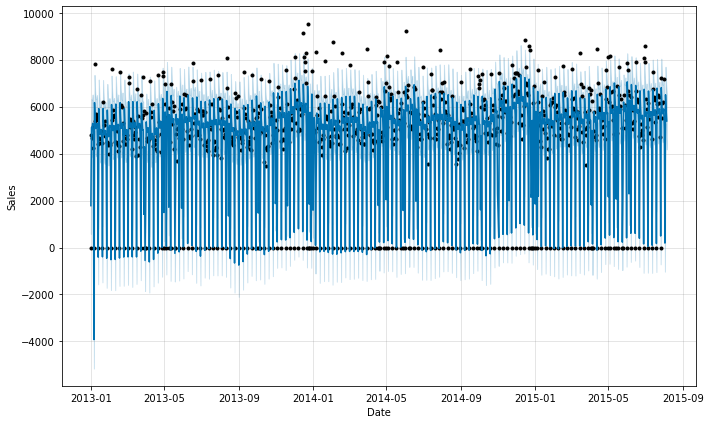

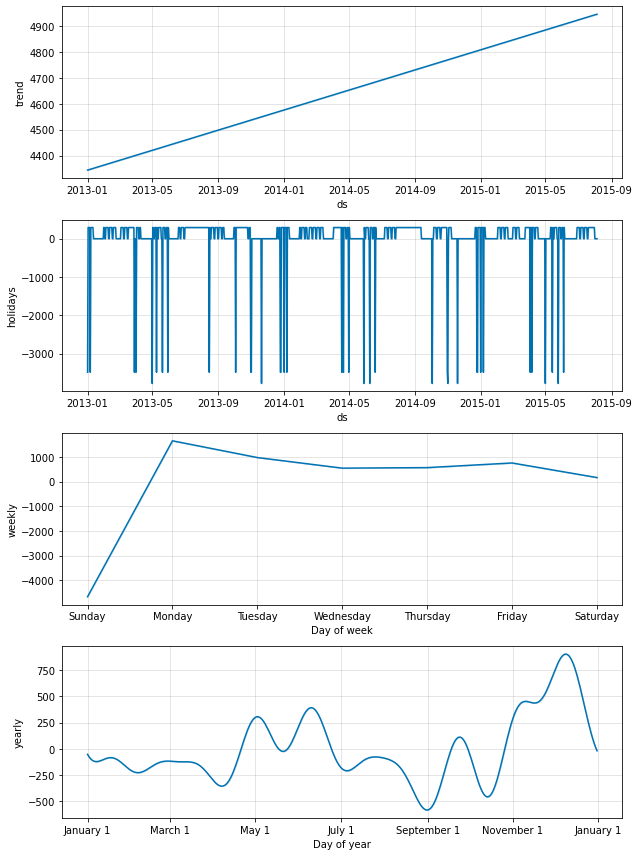

In [106]:
df_original, df_prediction = sales_prediction(10, merged_data, school_state_holidays, 5)

In [107]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,4344.062890,585.716414,3040.620969,4344.062890,4344.062890,-2562.060093,-2562.060093,-2562.060093,-3485.342662,...,975.584208,975.584208,975.584208,-52.301639,-52.301639,-52.301639,0.0,0.0,0.0,1782.002796
1,2013-01-02,4344.698126,3854.316295,6324.140689,4344.698126,4344.698126,763.840527,763.840527,763.840527,291.946636,...,546.177122,546.177122,546.177122,-74.283231,-74.283231,-74.283231,0.0,0.0,0.0,5108.538653
2,2013-01-03,4345.333361,3849.946532,6293.972211,4345.333361,4345.333361,767.775654,767.775654,767.775654,291.946636,...,567.516442,567.516442,567.516442,-91.687424,-91.687424,-91.687424,0.0,0.0,0.0,5113.109015
3,2013-01-04,4345.968597,4095.262579,6517.658054,4345.968597,4345.968597,943.043914,943.043914,943.043914,291.946636,...,755.849574,755.849574,755.849574,-104.752296,-104.752296,-104.752296,0.0,0.0,0.0,5289.012511
4,2013-01-05,4346.603833,3496.114238,5942.821294,4346.603833,4346.603833,342.657324,342.657324,342.657324,291.946636,...,164.513073,164.513073,164.513073,-113.802385,-113.802385,-113.802385,0.0,0.0,0.0,4689.261157
